In [1]:
import requests
import cv2
from matplotlib import pyplot as plt 
import numpy as np


from utils import *

## Gradient distribution

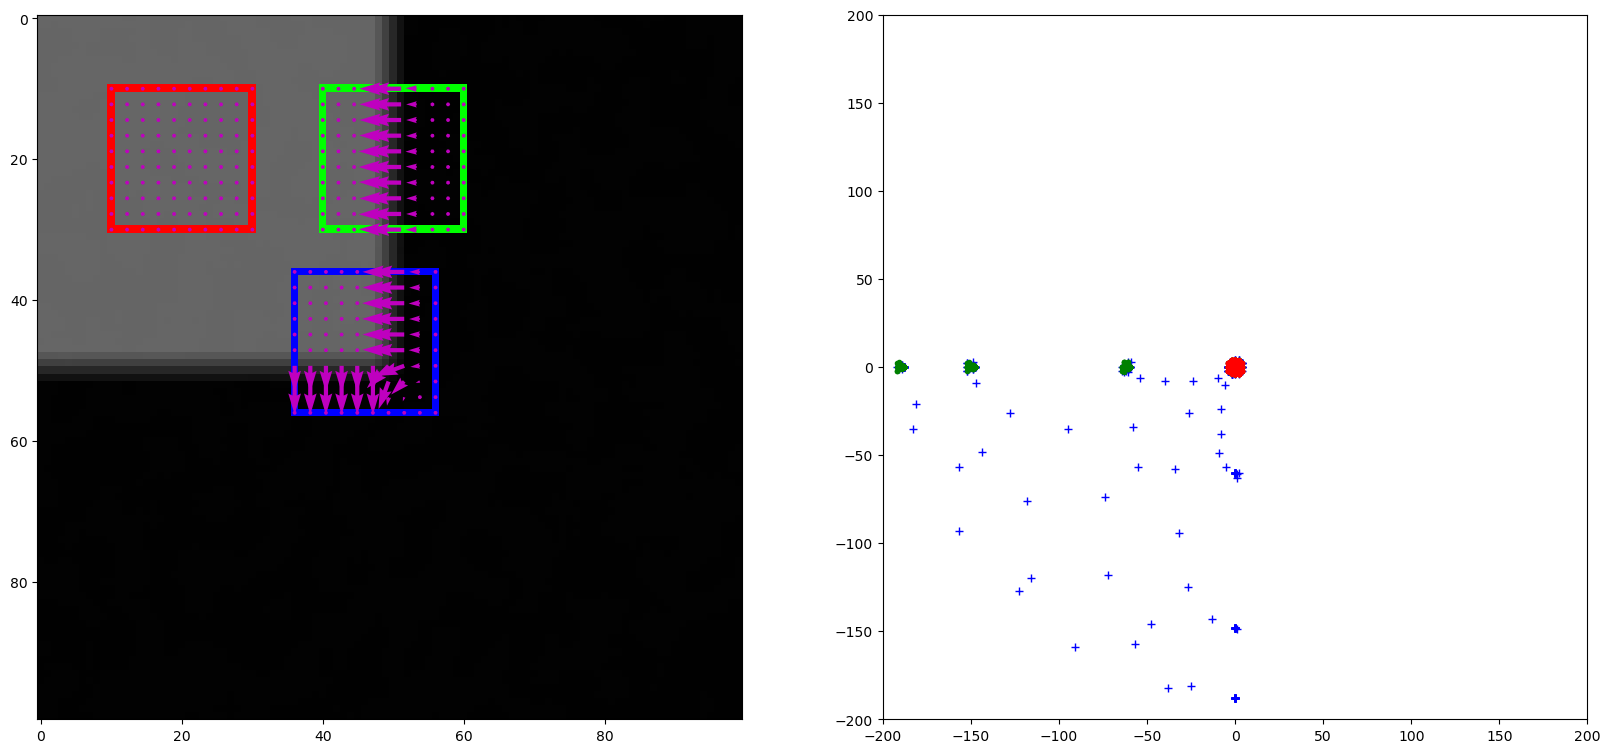

In [2]:
# Create a black image (all zeros) with dimensions 100 x 100 and 3 channels (for color)
image = np.random.randint(0,4,(100,100),dtype=np.uint8) # generating a random image with pixel values between 0 and 3
image[:50, :50] += 100                                  # top-left quarter made brighter (increasing pixel vals)
image = cv2.GaussianBlur(image, (5,5), 2)


l = 20
box1 = (10,10)                                                                          # Look at 3 boxes within the image
box2 = (10,40)
box3 = (36,36)

# Apply sobel edge detection
sobelx = cv2.Sobel(src=image, ddepth=cv2.CV_64F, dx=1, dy=0, ksize=3) 
sobely = cv2.Sobel(src=image, ddepth=cv2.CV_64F, dx=0, dy=1, ksize=3) 
drv = np.dstack((sobelx, sobely))                       # stacking x & y derivatives into a 3-channel array (drv) 
                                                        # drv has 2 channels for each of the derivatives

# Compute the derivatives for the 3 boxes
drv1 = drv[box1[0]:box1[0]+l, box1[1]: box1[1]+l,:]     # drv1 corresponds to the region inside the first box  
                                                        # box1[0] = row/vertical coordinate, box1[1] = col/horizontal coordinate
                                                        # box1[0]:box1[0] + l --> slice from the row coordinate up to (excluding) box1[0] + l
                                                        #   defining the vertical range of the box
                                                        # box1[1]:box1[1] + l --> defining the horizontal range of the box
                                                        # : --> extract all channels for the rows/cols we just specified
drv2 = drv[box2[0]:box2[0]+l, box2[1]: box2[1]+l,:]
drv3 = drv[box3[0]:box3[0]+l, box3[1]: box3[1]+l,:]

# Compute the magnitude of the derivatives for each box
mag1 = np.linalg.norm(drv1, axis=2)
mag2 = np.linalg.norm(drv2, axis=2)
mag3 = np.linalg.norm(drv3, axis=2)

# Display the image and derivatives
plt.figure(figsize=(20, 10))
plt.subplot(1,2,1)
image_ = image.copy()
image_ = np.repeat(image_[:,:,np.newaxis],3, axis=2)
cv2.rectangle(image_, (box1[1], box1[0]), (box1[1]+l, box1[0]+l), (255, 0, 0), 1)           #create the first box by specifying the 2 points of the rectangle and setting the color to red
cv2.rectangle(image_, (box2[1], box2[0]), (box2[1]+l, box2[0]+l), (0, 255, 0), 1)           #create the second box by specifying the 2 points of the rectangle and setting the color to green
cv2.rectangle(image_, (box3[1], box3[0]), (box3[1]+l, box3[0]+l), (0, 0, 255), 1)           #create the third box by specifying the 2 points of the rectangle and setting the color to blue
plt.imshow(image_)
plt.quiver(np.linspace(box1[1], box1[1]+l, int(l/2)),                                       #quiver is used to show the pink lines below indicating the edge/corner direction
           np.linspace(box1[0], box1[0]+l, int(l/2)),
           drv1[::2,::2,0], drv1[::2,::2,1], color='m', scale = 4000
           )
plt.quiver(np.linspace(box2[1], box2[1]+l, int(l/2)), 
           np.linspace(box2[0], box2[0]+l, int(l/2)),
           drv2[::2,::2,0], drv2[::2,::2,1], color='m', scale = 4000
           )
plt.quiver(np.linspace(box3[1], box3[1]+l, int(l/2)), 
           np.linspace(box3[0], box3[0]+l, int(l/2)),
           drv3[::2,::2,0], drv3[::2,::2,1], color='m', scale = 4000,
           )


axs = plt.subplot(1,2,2)                                                                    # plotting the derivatives of the boxes as scatter points
plt.plot(drv3.reshape(-1,2)[:,0], drv3.reshape(-1,2)[:,1],'b+')                             # this shows that corners have change in both x and y directions
plt.xlim(-200,200)
plt.ylim(-200,200)

plt.plot(drv2.reshape(-1,2)[:,0], drv2.reshape(-1,2)[:,1],'g.')
plt.xlim(-200,200)
plt.ylim(-200,200)

plt.plot(drv1.reshape(-1,2)[:,0], drv1.reshape(-1,2)[:,1],'r.')
plt.xlim(-200,200)
plt.ylim(-200,200)

axs = plt.gca()
axs.set_aspect('equal')

# You can see that the Green is an edge since the dots are in a straight line (derivative along x, derivative along y is almost 0)
# Blue is a corner since the dots are in different directions

## Harris Corner detection

(Text(0.5, 1.0, 'Image'), ([], []), ([], []))

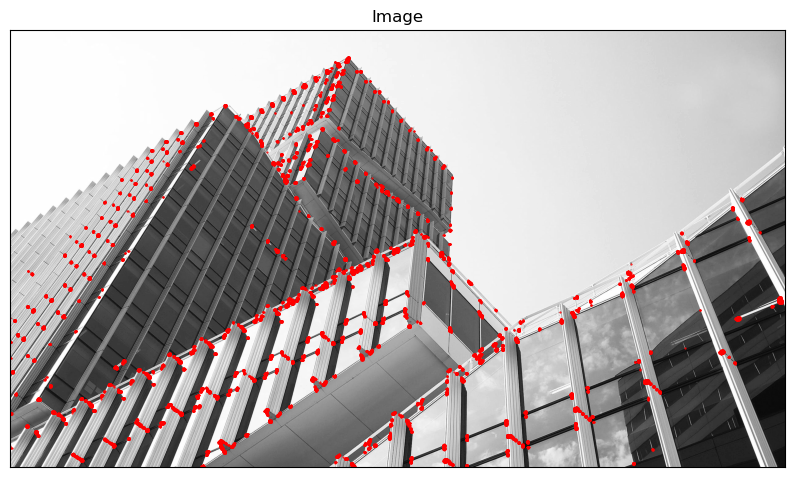

In [7]:
# Read the image
image = getImage('https://images.pexels.com/photos/162539/architecture-building-amsterdam-blue-sky-162539.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=2', cv2.IMREAD_GRAYSCALE)

# Apply the Harris Corner Detector
harris_response = cv2.cornerHarris(image, blockSize=7, ksize=5, k=0.04)             # blockSize = size of the window on which we'll compute the Harris matrix
                                                                                    #   here we chose 7x7 window (49 derivatives)
                                                                                    #   increasing window --> corner you're locating may not be localized (effect depends on the image)

                                                                                    # ksize = Sobel Operator Size 
                                                                                    #   we defined the window as 5 x 5, but blockSize & ksize can be the same size
                                                                                    
                                                                                    # !!! What is the effect of k on R? (Possible Exam Question) !!!
                                                                                    #   Remember, k is just a scalar (affects sensitivity to corners)

                                                                                    #   Bigger k gives you less false corners (you will get less false corners, but you miss more real ones --> high precision)
                                                                                    #       Gives us only the strongest corners (assuming threshold is kept as is)
                                                                                    #   Smaller k gives you more corners (you miss less true corners, but you get a lot of false ones --> high recall)
                                                                                    #       Explanation: assign a corner only if the det is relatively higher than the trace
                                                                                    #       Basically, smaller k = larger R vals = more corners since more R vals are higher than the threshold

                                                                                    # harris_response is now an image (same size as original)

# Threshold the response to identify corners
threshold = 0.05 * harris_response.max()                                            # more corners when we lower the threshold !!!
corner_mask = (harris_response > threshold).astype(np.uint8) * 255                  # If you want the coordinates, you can say coordinates = np.where(corner_mask)
                                                                                    # corner_mask --> binary image where white pixels represent corners 
                                                                                    # pixels with harris_response > threshold --> corner

# Get the x, y coordinates of the corners
coordinates = np.column_stack(np.where(corner_mask > 0))                            # np.column_stack(coordinates).shape --> shows you how many points you have
                                                                                    # just a matter of storage, you don't have to stack
                                                                                    # not corner = 0, corner = 255

# Display the original image and detected corners
plt.figure(figsize=(10, 10))

plt.subplot(111), plt.imshow(image, cmap='gray')
plt.scatter(coordinates[:, 1], coordinates[:, 0], color='red', marker='.', s=1)     # You need to plot columns (1) and then rows (0) --> otherwise, it'll be flipped
# plt.scatter(coordinates[1], coordinates[0], color='red', marker='.', s=1)         # x goes left to right (row) and y is up and down (column), which is why we flip them when plotting
plt.title('Image'), plt.xticks([]), plt.yticks([])

# plt.imshow(harris_response, cmap='gray')                                          # we can plot the harris response as well